In [ ]:
!pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
#2
from PyPDF2 import PdfReader
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import seaborn as sns


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#1.Генерирация русских имен при помощи RNN

Датасет: https://disk.yandex.ru/i/2yt18jHUgVEoIw

1.1 На основе файла name_rus.txt создайте датасет.
  * Учтите, что имена могут иметь различную длину
  * Добавьте 4 специальных токена:
    * `<PAD>` для дополнения последовательности до нужной длины;
    * `<UNK>` для корректной обработки ранее не встречавшихся токенов;
    * `<SOS>` для обозначения начала последовательности;
    * `<EOS>` для обозначения конца последовательности.
  * Преобразовывайте строку в последовательность индексов с учетом следующих замечаний:
    * в начало последовательности добавьте токен `<SOS>`;
    * в конец последовательности добавьте токен `<EOS>` и, при необходимости, несколько токенов `<PAD>`;
  * `Dataset.__get_item__` возращает две последовательности: последовательность для обучения и правильный ответ.
  
  Пример:
  ```
  s = 'The cat sat on the mat'
  # преобразуем в индексы
  s_idx = [2, 5, 1, 2, 8, 4, 7, 3, 0, 0]
  # получаем x и y (__getitem__)
  x = [2, 5, 1, 2, 8, 4, 7, 3, 0]
  y = [5, 1, 2, 8, 4, 7, 3, 0, 0]
  ```



### а)чтение и создание словаря


In [ ]:
path_names = '/content/drive/MyDrive/Datasets/NLP/07_RNN/name_rus.csv'
names = pd.read_csv(path_names, header = None, encoding = 'cp1251')
names[0] = names[0].str.lower()
names.head(2)


,0
0,авдокея
1,авдоким


In [ ]:
class Vocab_names():
  def __init__(self, data):
    #data - dataframe
    self.chars = set(''.join([row[0].lower() for row in data.values]))
    sp_tokens = {0 : 'PAD', 1 : 'UNK', 2 : 'SOS', 3 : 'EOS'}
    self.int2char = sp_tokens | dict(enumerate(self.chars, 4))
    self.char2int= {val:key for key, val in self.int2char.items()}
    self.max_name_len = max(data.iloc[:, 0].apply(lambda x: len(x)))
    self.vocab_len = len(self.int2char)

  def into_nums(self, seq):
    return [self.char2int[char] if char in self.chars else self.vocab.char2int['UNK'] for char in seq]

  def into_chars(self, seq):
    return [self.int2char[int_]  for int_ in seq]




In [ ]:
v1 = Vocab_names(names)

In [ ]:
n1 = v1.into_nums('александр')
n1

[29, 17, 14, 15, 28, 29, 31, 10, 5]

In [ ]:
ch1 = v1.into_chars(n1)
ch1

['а', 'л', 'е', 'к', 'с', 'а', 'н', 'д', 'р']

### б)создание датасета

In [ ]:
class NamesDataset(Dataset):
  def __init__(self, data, vocab):
    self.data = data
    self.vocab = vocab
  def to_sequence(self, name, for_y = False):
      name_len = len(name)

      start = [self.vocab.char2int['SOS']]
      body = self.vocab.into_nums(name)
      padding = [self.vocab.char2int['PAD'] for i in range(self.vocab.max_name_len - name_len)]
      end = [self.vocab.char2int['EOS']]

      if for_y:
          return torch.LongTensor(body + end + padding + [0])
      return torch.LongTensor(start + body + end + padding )



  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    x = self.to_sequence(self.data.iloc[idx, 0])
    y = self.to_sequence(self.data.iloc[idx, 0], for_y = True)
    return x, y

In [ ]:
d1 = NamesDataset(names, v1)

In [ ]:
x1, y1 = d1[0]
print(v1.into_chars(x1.tolist()), '\n',v1.into_chars(y1.tolist()))

['SOS', 'а', 'в', 'д', 'о', 'к', 'е', 'я', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'] 
 ['а', 'в', 'д', 'о', 'к', 'е', 'я', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


### в)разбиение на тестовую и обучающую


In [ ]:
names_train, names_test = train_test_split(names, test_size=0.15, random_state=1)

In [ ]:
max_len = v1.max_name_len

train_dataset = NamesDataset(names_train, v1)
test_dataset = NamesDataset(names_test, v1)

train_loader = DataLoader(train_dataset, batch_size= 128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = len(names_test))

## 1.2 Создайте и обучите модель для генерации фамилии.

  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`;
  * Используйте рекуррентные слои;
  * Задача ставится как предсказание следующего токена в каждом примере из пакета для каждого момента времени. Т.е. в данный момент времени по текущей подстроке предсказывает следующий символ для данной строки (задача классификации);
  * Примерная схема реализации метода `forward`:
  ```
    input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
    emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size]
    output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
    output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
  ```



In [ ]:
num_classes = v1.vocab_len
max_len = v1.max_name_len + 2

class RNN_custom(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
    super().__init__()
    self.rnn_hidden_size = rnn_hidden_size

    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size, batch_first = True)
    self.classifier = nn.Sequential(
                                    nn.Linear(rnn_hidden_size, rnn_hidden_size),
                                    nn.ReLU(),
                                    nn.Dropout(0.15),

                                    nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.1)

  def forward(self, X):
    out = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(out) # batch x rnn_hidden

    out = out.contiguous().view(-1, self.rnn_hidden_size)
    #out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out

In [ ]:
model = RNN_custom(v1.vocab_len,
                  embedding_size=100,
                  rnn_hidden_size=64,
                  num_classes = num_classes,
                  #n_layers = 1
                   )

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = MultiStepLR(optimizer, milestones=[50, 60, 70, 80, 100], gamma=0.1)

In [ ]:
n_epochs = 101
for epoch in tqdm(range(n_epochs)):
  model.train()

  for X_batch, y_batch in train_loader:
      predictions = model(X_batch)
      loss = criterion(predictions, y_batch.view(-1).long())

      loss.backward()
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()


  if epoch%5 == 0:
      with torch.no_grad():
        for X_batch, y_batch in test_loader:
          predictions = model(X_batch)
          y_real = y_batch.view(-1).long()
          loss_v = criterion(predictions, y_real)
          acc = (predictions.argmax(-1) == y_real).float().mean()
          print(f'\n\n|Epoch {epoch + 1}\nTrain_loss: {loss : .4f}\nVAL_loss: {loss_v : .4f}\nVal accuracy: {acc : .3%}\n')

  1%|          | 1/101 [00:00<01:06,  1.50it/s]



|Epoch 1
Train_loss:  1.0768
VAL_loss:  1.1428
Val accuracy:  67.269%



  6%|▌         | 6/101 [00:02<00:43,  2.19it/s]



|Epoch 6
Train_loss:  0.8255
VAL_loss:  0.9043
Val accuracy:  71.215%



 11%|█         | 11/101 [00:05<00:40,  2.22it/s]



|Epoch 11
Train_loss:  0.8527
VAL_loss:  0.9067
Val accuracy:  71.171%



 16%|█▌        | 16/101 [00:07<00:38,  2.20it/s]



|Epoch 16
Train_loss:  0.8844
VAL_loss:  0.9101
Val accuracy:  71.104%



 21%|██        | 21/101 [00:10<00:50,  1.59it/s]



|Epoch 21
Train_loss:  0.8595
VAL_loss:  0.9058
Val accuracy:  70.836%



 26%|██▌       | 26/101 [00:13<00:49,  1.52it/s]



|Epoch 26
Train_loss:  0.8773
VAL_loss:  0.9046
Val accuracy:  71.148%



 31%|███       | 31/101 [00:16<00:35,  2.00it/s]



|Epoch 31
Train_loss:  0.9179
VAL_loss:  0.9050
Val accuracy:  71.171%



 36%|███▌      | 36/101 [00:18<00:29,  2.18it/s]



|Epoch 36
Train_loss:  0.9215
VAL_loss:  0.9038
Val accuracy:  71.237%



 41%|████      | 41/101 [00:20<00:26,  2.25it/s]



|Epoch 41
Train_loss:  0.8374
VAL_loss:  0.9063
Val accuracy:  71.327%



 46%|████▌     | 46/101 [00:22<00:24,  2.24it/s]



|Epoch 46
Train_loss:  0.9343
VAL_loss:  0.9062
Val accuracy:  70.903%



 50%|█████     | 51/101 [00:25<00:26,  1.89it/s]



|Epoch 51
Train_loss:  1.0136
VAL_loss:  0.9076
Val accuracy:  70.992%



 55%|█████▌    | 56/101 [00:28<00:28,  1.56it/s]



|Epoch 56
Train_loss:  0.8123
VAL_loss:  0.9055
Val accuracy:  71.037%



 60%|██████    | 61/101 [00:31<00:25,  1.55it/s]



|Epoch 61
Train_loss:  0.9100
VAL_loss:  0.9025
Val accuracy:  71.037%



 65%|██████▌   | 66/101 [00:34<00:16,  2.10it/s]



|Epoch 66
Train_loss:  0.8104
VAL_loss:  0.9090
Val accuracy:  70.992%



 70%|███████   | 71/101 [00:36<00:13,  2.18it/s]



|Epoch 71
Train_loss:  0.9822
VAL_loss:  0.9129
Val accuracy:  71.014%



 75%|███████▌  | 76/101 [00:38<00:11,  2.24it/s]



|Epoch 76
Train_loss:  0.8749
VAL_loss:  0.9077
Val accuracy:  71.394%



 80%|████████  | 81/101 [00:40<00:08,  2.23it/s]



|Epoch 81
Train_loss:  0.9037
VAL_loss:  0.9054
Val accuracy:  71.438%



 85%|████████▌ | 86/101 [00:43<00:08,  1.69it/s]



|Epoch 86
Train_loss:  0.8305
VAL_loss:  0.9051
Val accuracy:  71.282%



 90%|█████████ | 91/101 [00:46<00:06,  1.53it/s]



|Epoch 91
Train_loss:  0.9018
VAL_loss:  0.9057
Val accuracy:  71.260%



 95%|█████████▌| 96/101 [00:49<00:02,  1.79it/s]



|Epoch 96
Train_loss:  0.9587
VAL_loss:  0.9088
Val accuracy:  70.925%



100%|██████████| 101/101 [00:51<00:00,  1.94it/s]



|Epoch 101
Train_loss:  0.7819
VAL_loss:  0.9086
Val accuracy:  71.037%



### save model

In [ ]:
PATH = '/content/drive/MyDrive/Datasets/DL/models/model_rnn_generate_names.ckpt'
torch.save(model.state_dict(), PATH)

### load model

In [ ]:
path_load1 = '/content/drive/MyDrive/Datasets/DL/models/model_rnn_generate_names.ckpt'
model.load_state_dict(torch.load(path_load1))

<All keys matched successfully>

1.3 Напишите функцию, которая генерирует имя при помощи обученной модели:
  * Построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * Начальное скрытое состояние RNN `h_t = None`;
  * В результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * Выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * Повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности.

При обучении каждые `k` эпох генерируйте несколько фамилий и выводите их на экран.

In [ ]:
def predict(model, vocab, chars):
  char_in_num = [2] + vocab.into_nums(chars)
  char_in_num = torch.LongTensor(char_in_num)
  out = model(char_in_num)
  out = out[-1].argmax(-1).item()

  return v1.into_chars([out])[0]

In [ ]:
def generate(beginning, vocab):
    chars = list(beginning)
    max_len = vocab.max_name_len

    try:
        assert len(chars) < max_len

    except AssertionError:
        print('Максимальная длина для генерации имени достигнута или превышена')
        print(f'Максимум: {max_len}, Принято: {len(chars)}')

    for i in range(max_len - len(chars)):
        new_char = predict(model, vocab, chars)
        if new_char == 'EOS':
            print('Полное имя')
            break
        chars += [new_char]
    else:
        print('Имя достигло максимальной длины')
    return ''.join(chars)



In [ ]:
generate('', v1)

Полное имя


'аната'

In [ ]:
generate('вал', v1)

Полное имя


'валека'

In [ ]:
generate('га', v1)

Полное имя


'гарина'

In [ ]:
generate('анас', v1)

Полное имя


'анаста'

In [ ]:
generate('к', v1)

Полное имя


'килина'

#2.Генерирация текста при помощи RNN



Ссылка на датасет
https://drive.google.com/drive/folders/1alf4JoonxBd9fCq2QqKRbgTwHkp4UAQ-?usp=sharing

2.1 Скачайте из интернета какое-нибудь художественное произведение
  * Выбирайте достаточно крупное произведение, чтобы модель лучше обучалась;



In [ ]:
def to_sent(text):
    sents = sent_tokenize(text)
    sents = [re.sub(r'[\W]', ' ', sent.lower()) for sent in sents]

    return [word_tokenize(sent) for sent in sents]

In [ ]:
def collect_text(path, start_page = 1):
    reader = PdfReader(path)
    last_page = len(reader.pages)
    text = ' '.join([reader.pages[ind].extract_text() for ind in tqdm(range(start_page, last_page))])

    return to_sent(text)

In [ ]:
pathb2 = '/content/drive/MyDrive/Datasets/NLP/emotions/Remark_The-Black-Obelisk.pdf'

In [ ]:
text = collect_text(pathb2)

100%|██████████| 231/231 [00:31<00:00,  7.25it/s]


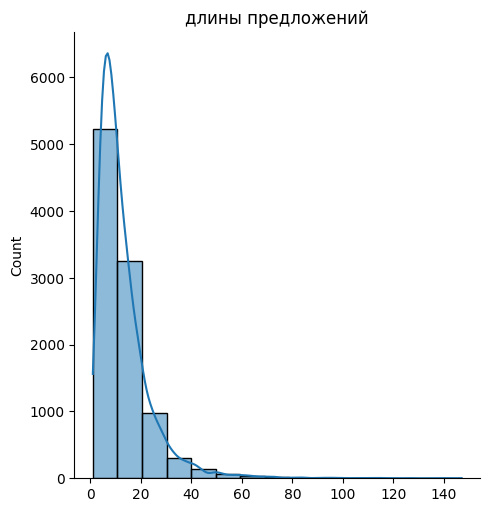

In [ ]:
lens = list(map(len, text))
ax = sns.displot(lens, kde=True, bins=15);
ax.set(title = 'длины предложений');

In [ ]:
max(lens)

147

2.2 На основе выбранного произведения создайте датасет.

Отличия от задачи 1:
  * Токены <SOS>, `<EOS>` и `<UNK>` можно не добавлять;
  * При создании датасета текст необходимо предварительно разбить на части. Выберите желаемую длину последовательности `seq_len` и разбейте текст на построки длины `seq_len` (можно без перекрытия, можно с небольшим перекрытием).



In [ ]:
class Vocab_text():
  def __init__(self, data):
    self.unique_words = set()
    for i in text:
      self.unique_words.update(i)

    sp_tokens = {0 : 'PAD', 1 : 'SOS'}
    self.int2word = sp_tokens | dict(enumerate(self.unique_words, 2))
    self.word2int= {val:key for key, val in self.int2word.items()}
    self.max_len = len(max(text, key = len))
    self.vocab_len = len(self.int2word)

  def into_nums(self, seq):
    return [self.word2int[word]  for word in seq]

  def into_words(self, seq):
    return [self.int2word[int_]  for int_ in seq]




In [ ]:
v2 = Vocab_text(text)

In [ ]:
v2.into_nums(['a', 'human'])

[6674, 7933]

In [ ]:
v2.into_words([9135, 1639])

['afloat', 'guard']

In [ ]:
class TextDataset(Dataset):
  def __init__(self, data, vocab):
    self.data = data
    self.vocab = vocab
  def to_sequence(self, sent, for_y = False):

      start = [self.vocab.word2int['SOS']]
      body = self.vocab.into_nums(sent)
      padding = [self.vocab.word2int['PAD'] for i in range(self.vocab.max_len - len(sent))]


      if for_y:
          return torch.LongTensor(body  + padding + [0])
      return torch.LongTensor(start + body + padding )



  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    x = self.to_sequence(self.data[idx])
    y = self.to_sequence(self.data[idx], for_y = True)
    return x, y

In [ ]:
d2 = TextDataset(text, v2)

In [ ]:
d2[4]

(tensor([   1, 1482, 8512, 4698, 5281, 8425, 6049, 5109, 9642, 9971, 3379, 8425,
         3782, 7243,  721, 7352, 8886, 2357, 5016, 6749, 3379, 7573, 4554, 6669,
         3379, 1482,  410, 8425, 7453,  220, 6602, 3122, 8512, 3379, 4698,  410,
         7419, 1343, 8512, 6148, 8425,  265, 1466, 5045, 7549, 2435, 6674, 9263,
         3379, 7549, 3424, 6674, 8953,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

### в)разбиение на тестовую и обучающую


In [ ]:
train_data, test_data = train_test_split(text, test_size=0.05, random_state=1)

In [ ]:
train_dataset = TextDataset(train_data, v2)
test_dataset = TextDataset(test_data, v2)

train_loader = DataLoader(train_dataset, batch_size= 128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = len(test_data))

2.3 Создайте и обучите модель для генерации текста
  * Задача ставится точно так же как в 1.2;
  * При необходимости можете применить:
    * двухуровневые рекуррентные слои (`num_layers`=2)
    * [обрезку градиентов](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)



In [ ]:
num_classes = v2.vocab_len
max_len = v2.max_len + 1

class RNN_custom(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
    super().__init__()
    self.rnn_hidden_size = rnn_hidden_size

    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size, batch_first = True)
    self.classifier = nn.Sequential(
                                    nn.Linear(rnn_hidden_size, rnn_hidden_size),
                                    nn.ReLU(),
                                    nn.Dropout(0.15),

                                    nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.1)

  def forward(self, X):
    out = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(out) # batch x rnn_hidden

    out = out.contiguous().view(-1, self.rnn_hidden_size)
    #out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RNN_custom(v2.vocab_len,
                  embedding_size=256,
                  rnn_hidden_size=200,
                  num_classes = num_classes,
                  #n_layers = 1
                   ).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
#scheduler = MultiStepLR(optimizer, milestones=[50, 60, 70, 80, 100], gamma=0.1)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
n_epochs = 10
for epoch in tqdm(range(n_epochs)):
  model.train()

  for X_batch, y_batch in tqdm(train_loader):
      X_batch, y_batch =  X_batch.to(device), y_batch.to(device)
      predictions = model(X_batch)
      loss = criterion(predictions, y_batch.view(-1).long())

      loss.backward()
      optimizer.step()
      #scheduler.step()
      optimizer.zero_grad()


  with torch.no_grad():
    for X_batch, y_batch in test_loader:
      X_batch, y_batch =  X_batch.to(device), y_batch.to(device)
      predictions = model(X_batch)
      y_real = y_batch.view(-1).long()
      loss_v = criterion(predictions, y_real)
      acc = (predictions.argmax(-1) == y_real).float().mean()
      print(f'\n\n|Epoch {epoch + 1}\nTrain_loss: {loss : .4f}\nVAL_loss: {loss_v : .4f}\nVal accuracy: {acc : .3%}\n')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]



|Epoch 1
Train_loss:  0.5873
VAL_loss:  0.5825
Val accuracy:  91.511%



  0%|          | 0/75 [00:00<?, ?it/s]



|Epoch 2
Train_loss:  0.6189
VAL_loss:  0.5588
Val accuracy:  91.718%



  0%|          | 0/75 [00:00<?, ?it/s]



|Epoch 3
Train_loss:  0.5341
VAL_loss:  0.5504
Val accuracy:  91.827%



  0%|          | 0/75 [00:00<?, ?it/s]



|Epoch 4
Train_loss:  0.4790
VAL_loss:  0.5541
Val accuracy:  91.909%



  0%|          | 0/75 [00:00<?, ?it/s]



|Epoch 5
Train_loss:  0.5580
VAL_loss:  0.5669
Val accuracy:  91.861%



  0%|          | 0/75 [00:00<?, ?it/s]



|Epoch 6
Train_loss:  0.3788
VAL_loss:  0.5839
Val accuracy:  91.903%



  0%|          | 0/75 [00:00<?, ?it/s]



|Epoch 7
Train_loss:  0.3670
VAL_loss:  0.5979
Val accuracy:  91.853%



  0%|          | 0/75 [00:00<?, ?it/s]



|Epoch 8
Train_loss:  0.3246
VAL_loss:  0.6258
Val accuracy:  91.854%



  0%|          | 0/75 [00:00<?, ?it/s]



|Epoch 9
Train_loss:  0.3919
VAL_loss:  0.6445
Val accuracy:  91.764%



  0%|          | 0/75 [00:00<?, ?it/s]



|Epoch 10
Train_loss:  0.3454
VAL_loss:  0.6698
Val accuracy:  91.741%



2.4 Напишите функцию, которая генерирует фрагмент текста при помощи обученной модели
  * Процесс генерации начинается с небольшого фрагмента текста `prime`, выбранного вами (1-2 слова)
  * Сначала вы пропускаете через модель токены из `prime` и генерируете на их основе скрытое состояние рекуррентного слоя `h_t`;
  * После этого вы генерируете строку нужной длины аналогично 1.3


In [ ]:
loss

tensor(0.3454, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
def predict(model, vocab, seq):
  char_in_num = [2] + vocab.into_nums(seq)
  char_in_num = torch.LongTensor(char_in_num).to(device)
  result = model(char_in_num)

  out = result[-1].argmax(-1).item()

  if out == 0:
      out = result[-1].argsort()[-2].item()
  return vocab.into_words([out])[0]

In [ ]:
seq = ['i', 'am', 'human', 'who']

In [ ]:
predict(model, v2, seq)

'have'

In [ ]:
def generate(beginning, vocab, iters):
    seq = beginning[:]
    pred = []

    max_len = vocab.max_len
    for i in range(iters):
        new_word = predict(model, vocab, seq)
        seq += [new_word]
        pred += [new_word]



    return ' '.join(beginning + ['!!!!!!!!!!!'] + pred)



In [ ]:
print(generate(text[4], v2, 10))

autumn and spring are the best seasons for dealers in the appurtenances of grief more people die then than in summer or winter in autumn because the sap has dried up and in spring because it mounts and consumes the weakened body like too large a wick in too thin a candle !!!!!!!!!!! glow in the morning sun and the red bed of


In [ ]:
print(generate(text[10], v2, 15))

there is no profit in urns !!!!!!!!!!! and i say realizing that he can t get out of his mind when i


In [ ]:
print(generate(text[125], v2, 15))

and i can t scrape together the price of a tie georg grins !!!!!!!!!!! behind his misdemeanors with the war sonnets had been dedicated and then he had been


In [ ]:
print(generate(['i', 'want', 'to'], v2, 20))

i want to !!!!!!!!!!! do with the red mill i say to be to do something like it and makes a woman in amazement
